In [2]:
import pandas as pd

In [3]:
contact_others = pd.read_csv('contact_others.csv')

In [6]:
import numpy as np

In [9]:
contact_others = np.array(contact_others)

1.7616939431484774e+25
1.17634732398938e+17
1.5644713366226507e+25
7.562538370530883e+16
267340504590510.56
52260319084139.14
1.710651546411698e+25
1.7726242173949254e+25
7.793504040452454e+24
161107045597357.72
7691334934425.999
8.473022316991781e+24
1.0490233704686195e+25
6.536789484489887e+24
42941619545710.83
2302720900506199.0
17839104894295.5
4.243166939984757e+16
8.191016838530814e+23
1.363288269255732e+24
2.2701590136876372e+16
4.2512456664357886e+23
4.3511520025017665e+21
3.842643999458465e+18
1.417647249622064e+24
3.9068641370187513e+23
3.1506493481140556e+19
1074.1004425313574
996.1003836694038
1012.0986319937573
979.5912823503891
974.0321542399637
970.6629072030157
970.7142190735789
972.3322907443937
970.1852365228158
970.0689036043742
969.9592312001914
969.9165652008104
969.9164408024245
969.91601384402
969.9150543001753
969.9152184696422


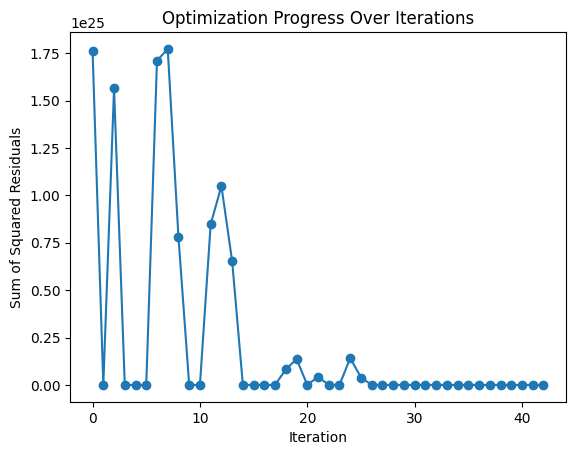

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Given data
N = np.array([4345, 58999, 55449, 807449, 186151, 462540, 28902, 32651])  # Number of transactions in each age category
P = np.array([4136344, 4100716, 3991988, 3934088, 4090149, 4141051, 3895117, 3439202,
              3075077, 3025100, 3031855, 2683253, 2187561, 1612948, 1088448, 1394217])  # Population vector

epsilon = 1e-6  # Small value to avoid division by zero
# Residuals function with W reshaped as 8x16
def residuals(W):
    W = W.reshape(8, 16)
    residuals = []
    for i1 in range(16):
        for i2 in range(16):
            estimated_C = sum(
                (W[j, i1] * N[j] / (sum(W[:, i2] * N) + epsilon)) * P[i2] +
                (W[j, i2] * N[j] / (sum(W[:, i1] * N) + epsilon )) * P[i1]
                for j in range(8)
            ) / P[i2]
            residuals.append(estimated_C - contact_others[i1, i2])
    return np.array(residuals)

# Constraint for row sum < 1
def row_sum_constraint(W):
    W = W.reshape(8, 16)
    return 1 - np.sum(W, axis=1)

# Additional bounds to ensure each W element is > 0
bounds = [(0, None) for _ in range(8 * 16)]

# Capture the residual sums across iterations
iteration_residuals = []

# Callback function to capture progress during optimization
def callback(W):
    # Calculate and store the sum of squared residuals for plotting
    print(np.sum(residuals(W) ** 2))
    iteration_residuals.append(np.sum(residuals(W) ** 2))

# Initial guess
initial_W = np.random.rand(8, 16).flatten()

# Minimize with constraints and bounds
result = minimize(
    lambda W: np.sum(residuals(W) ** 2),  # Objective: minimize squared residuals
    initial_W,
    constraints=[{'type': 'ineq', 'fun': row_sum_constraint}],
    bounds=bounds,
    method='SLSQP',
    callback=callback
)

# Reshape estimated W
W_estimated = result.x.reshape(8, 16)

# Plot the optimization progress
plt.plot(iteration_residuals, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Residuals')
plt.title('Optimization Progress Over Iterations')
plt.show()


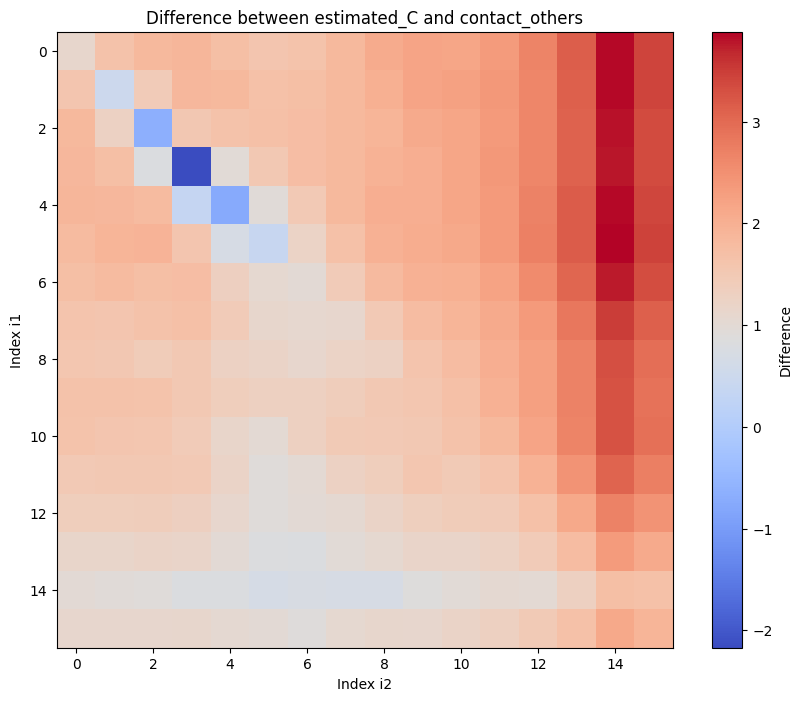

In [ ]:
# Calculate the estimated_C matrix based on the estimated W
estimated_C = np.zeros((16, 16))
for i1 in range(16):
    for i2 in range(16):
        estimated_C[i1, i2] = sum(
            (W_estimated[j, i1] * N[j] / (sum(W_estimated[:, i2] * N) + epsilon)) * P[i2] +
            (W_estimated[j, i2] * N[j] / (sum(W_estimated[:, i1] * N) + epsilon)) * P[i1]
            for j in range(8)
        ) / P[i2]

# Calculate the difference between estimated_C and contact_others
difference = estimated_C - contact_others

# Plot the difference using a color range
plt.figure(figsize=(10, 8))
plt.imshow(difference, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Difference')
plt.title('Difference between estimated_C and contact_others')
plt.xlabel('Index i2')
plt.ylabel('Index i1')
plt.show()

2.695105313076194e+33
1.25858390915318e+17
2.4581709388224116e+33
1.6782034022258847e+33
1501443726438709.5
3238083083325945.0
73745748794893.97
1.0893575622977482e+33
482573580174417.75
618456424498093.6
3.933011391093897e+33
804938148159697.6
2.0795442779760912e+33
8.834455264279214e+32
1.252969555771365e+16
4.616066925794768e+32
1.1428202145844064e+33
1.1173666611154177e+33
8.323001260138342e+32
3.812224575886191e+16
2.870338727134779e+32
6.21030266531316e+32
1.7658602185490186e+21
1.5052593706497516e+32
2.8814714365217475e+18
2.809525390073416e+32
1.7031660956481219e+18
9.206776052615392e+31
3.428461589240548e+17
2.4291901227505304e+19
979.1473507026699
5292.053212522854
986.105700920988
1003.9858058416625
971.9178573815424
970.0713151356857
969.9970025883074
970.1431600827715
970.1264287341354
970.0879471162393
969.9558824947611
969.952517361264
969.941800314582
969.9383258293855
969.937048088774
969.9359811088705
969.9343650172743
969.9327785296043
969.930835230683
969.9292257050

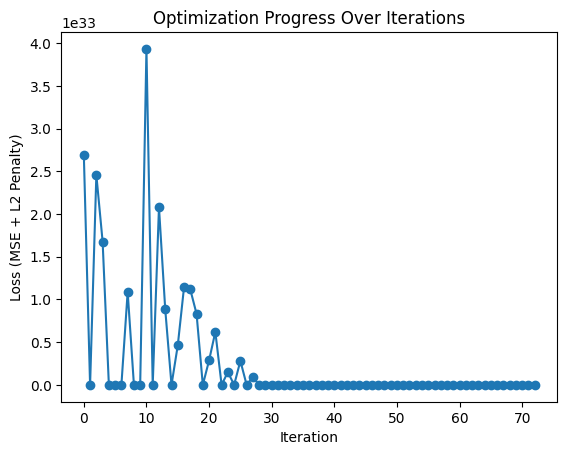

In [24]:
# Small epsilon to avoid division by zero
epsilon = 1e-10

# Loss function with regularization
def loss_with_regularization(W, alpha=0.1):
    W = W.reshape(8, 16)
    residuals = []
    for i1 in range(16):
        for i2 in range(16):
            estimated_C = sum(
                (W[j, i1] * N[j] / (sum(W[:, i2] * N) + epsilon)) * P[i2] +
                (W[j, i2] * N[j] / (sum(W[:, i1] * N) + epsilon)) * P[i1]
                for j in range(8)
            ) / (P[i2] + epsilon)
            residuals.append(estimated_C - contact_others[i1, i2])
    mse = np.sum(np.array(residuals) ** 2)
    l2_penalty = alpha * np.sum(W ** 2)  # L2 regularization term
    return mse + l2_penalty

# Constraint: Each row in W should sum to <= 1
def row_sum_constraint(W):
    W = W.reshape(8, 16)
    return 1 - np.sum(W, axis=1)

# Bounds for W elements: ensure each W[i][j] > 0
bounds = [(0, None) for _ in range(8 * 16)]

# Initial guess
initial_W = np.random.rand(8, 16).flatten()

# Track the loss over iterations
iteration_losses = []

# Callback function to track loss at each iteration
def callback(W):
    current_loss = loss_with_regularization(W)
    print(current_loss)
    iteration_losses.append(current_loss)

# Minimize with constraints and bounds
result = minimize(
    loss_with_regularization,
    initial_W.flatten(),
    constraints={'type': 'ineq', 'fun': row_sum_constraint},
    bounds=bounds,
    method='SLSQP',
    callback=callback
)

# Reshape estimated W
W_estimated = result.x.reshape(8, 16)

# Plot the optimization progress
plt.plot(iteration_losses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE + L2 Penalty)')
plt.title('Optimization Progress Over Iterations')
plt.show()